In [1]:
import pandas as pd

df = pd.read_csv('raw_data/Assignment_Data.csv')

### 1. preprocessing

In [2]:
cols_cat = ['gender', 'diagnosis_code', 'medication_type']

# get the dummy variables
df_processed = pd.get_dummies(df, columns=cols_cat, drop_first=True, dtype=float)

# get key phrases are mentioned or not
key_phrases = [
    'blood pressure',
    'minor discomfort',
    'rest and hydration',
    'current medication',
    'monitoring for relapse',
    'no further signs of infection'
]

for phrase in key_phrases:
    df_processed[f"{phrase}_mentioned"] = df_processed['discharge_note'].str.lower().str.contains(phrase).astype(float)
    
df_processed.head()

,patient_id,age,num_previous_admissions,length_of_stay,readmitted_30_days,discharge_note,gender_Male,diagnosis_code_D002,diagnosis_code_D003,diagnosis_code_D004,medication_type_Type B,medication_type_Type C,blood pressure_mentioned,minor discomfort_mentioned,rest and hydration_mentioned,current medication_mentioned,monitoring for relapse_mentioned,no further signs of infection_mentioned
0,1,71,3,2,0,Good recovery trajectory. Follow-up scan sched...,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,34,1,3,1,Stable post-surgery. Advised to avoid physical...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,80,2,5,1,Symptoms controlled. Monitoring for relapse ad...,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,4,40,2,11,0,Stable post-surgery. Advised to avoid physical...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,43,1,8,1,Stable post-surgery. Advised to avoid physical...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


### 2. Sanity check using random forest

In [3]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from sklearn.ensemble import RandomForestClassifier

clf = GridSearchCV(RandomForestClassifier(class_weight='balanced', random_state=42),
                   param_grid={'min_samples_split': [2,5,10,20,30,40,50]},
                   cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
                   scoring=['f1', 'roc_auc'],
                   refit='roc_auc',
                   verbose=3)

df_processed_train, df_processed_test = train_test_split(df_processed, random_state=42,
                                                         stratify=df_processed['readmitted_30_days'])

X = df_processed_train.drop(columns=['patient_id', 'discharge_note', 'readmitted_30_days'])
y = df_processed_train['readmitted_30_days']

clf.fit(X, y)
print(clf.best_params_, clf.best_score_)

Fitting 5 folds for each of 7 candidates, totalling 35 fits
[CV 1/5] END min_samples_split=2; f1: (test=0.500) roc_auc: (test=0.751) total time=   0.1s
[CV 2/5] END min_samples_split=2; f1: (test=0.526) roc_auc: (test=0.632) total time=   0.1s
[CV 3/5] END min_samples_split=2; f1: (test=0.000) roc_auc: (test=0.693) total time=   0.1s
[CV 4/5] END min_samples_split=2; f1: (test=0.000) roc_auc: (test=0.458) total time=   0.1s
[CV 5/5] END min_samples_split=2; f1: (test=0.588) roc_auc: (test=0.680) total time=   0.1s
[CV 1/5] END min_samples_split=5; f1: (test=0.471) roc_auc: (test=0.709) total time=   0.1s
[CV 2/5] END min_samples_split=5; f1: (test=0.455) roc_auc: (test=0.615) total time=   0.1s
[CV 3/5] END min_samples_split=5; f1: (test=0.154) roc_auc: (test=0.625) total time=   0.1s
[CV 4/5] END min_samples_split=5; f1: (test=0.200) roc_auc: (test=0.455) total time=   0.1s
[CV 5/5] END min_samples_split=5; f1: (test=0.471) roc_auc: (test=0.715) total time=   0.1s
[CV 1/5] END min_sam

/opt/anaconda3/lib/python3.9/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


In [4]:
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_recall_curve, average_precision_score

def generate_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    labels = [0, 1]
    
    # Convert to DataFrame for nicer plotting
    df_cm = pd.DataFrame(cm, index=labels, columns=labels)
    
    # Plot heatmap
    plt.figure(figsize=(5,4))
    sns.heatmap(df_cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()


def generate_precision_reall_curve(y_true, y_pred_proba):
    precision, recall, thresholds = precision_recall_curve(y_true, y_pred_proba)

    # Average precision score (area under PR curve)
    avg_precision = average_precision_score(y_true, y_pred_proba)
    
    # Plot
    plt.figure(figsize=(6,4))
    plt.plot(recall, precision, marker='.', label=f'AP = {avg_precision:.2f}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()
    plt.grid(True)
    plt.show()

roc_auc_score= 0.53125
              precision    recall  f1-score   support

           0       0.69      0.79      0.74        34
           1       0.36      0.25      0.30        16

    accuracy                           0.62        50
   macro avg       0.53      0.52      0.52        50
weighted avg       0.59      0.62      0.60        50



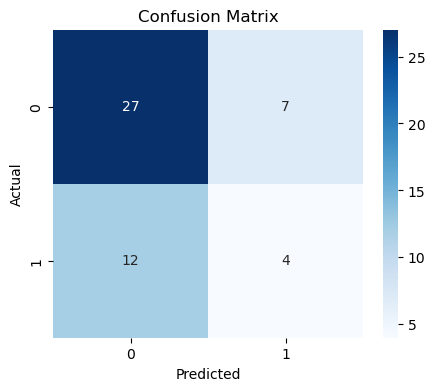

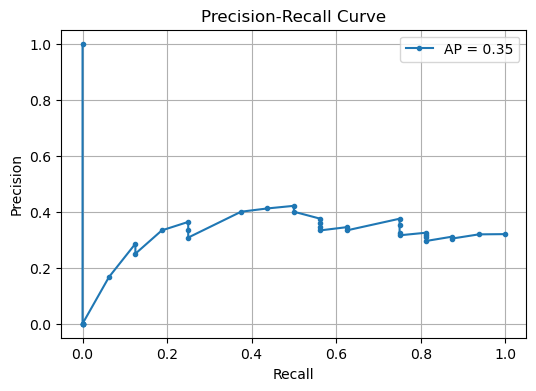

In [5]:
from sklearn.metrics import classification_report, f1_score, roc_auc_score, confusion_matrix

X_test = df_processed_test.drop(columns=['patient_id', 'discharge_note', 'readmitted_30_days'])
y_test_pred = clf.predict(X_test)
y_test_pred_prob = clf.predict_proba(X_test)[:,1]
y_test_true = df_processed_test['readmitted_30_days']
print('roc_auc_score=', roc_auc_score(y_test_true, y_test_pred_prob))
print(classification_report(y_test_true, y_test_pred))
generate_confusion_matrix(y_test_true, y_test_pred)
generate_precision_reall_curve(y_test_true, y_test_pred_prob)

### 3. More thorough comparison

In [6]:
X = df_processed.drop(columns=['patient_id', 'discharge_note', 'readmitted_30_days'])
y = df_processed['readmitted_30_days']

In [7]:
from sklearn.metrics import average_precision_score, roc_auc_score, f1_score

def get_many_aucs(clf, X, y, n_samples=10):
    aucs, f1s, aps = [], [], []
    for iseed in range(n_samples):
        X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=iseed)
        clf.fit(X_train, y_train)
        # params.append(clf.best_params_)
        print(clf.best_params_)
        
        y_test_pred = clf.predict(X_test)
        y_test_pred_proba = clf.predict_proba(X_test)[:,1]
        aucs.append(roc_auc_score(y_test, y_test_pred_proba))
        f1s.append(f1_score(y_test, y_test_pred))
        aps.append(average_precision_score(y_test, y_test_pred_proba))

    return aucs, f1s, aps

#### 3.1 Set up the Logistic Regression, which requires a scaler

In [8]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LogisticRegression

# set up the Logistic Regression, which requires a Scaler
cols_num = ['age', 'num_previous_admissions', 'length_of_stay']

preprocessor = ColumnTransformer([
    ('num', RobustScaler(), cols_num)
])

pipe = Pipeline([
    ('preprocess', preprocessor),
    ('clf', LogisticRegression(max_iter=500, solver='liblinear', class_weight='balanced'))
])

param_grid = {
    'clf__C': [0.01, 0.1, 1, 10],
    'clf__penalty': ['l1', 'l2']
}

clf = GridSearchCV(pipe, param_grid, scoring='roc_auc', 
                   cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True))

aucs_LR, f1s_LR, aps_LR = get_many_aucs(clf, X, y, n_samples=10)

{'clf__C': 0.01, 'clf__penalty': 'l2'}
{'clf__C': 0.01, 'clf__penalty': 'l2'}
{'clf__C': 0.1, 'clf__penalty': 'l1'}
{'clf__C': 0.01, 'clf__penalty': 'l2'}
{'clf__C': 0.1, 'clf__penalty': 'l1'}
{'clf__C': 0.01, 'clf__penalty': 'l1'}
{'clf__C': 0.1, 'clf__penalty': 'l2'}
{'clf__C': 0.01, 'clf__penalty': 'l2'}
{'clf__C': 0.01, 'clf__penalty': 'l2'}
{'clf__C': 0.01, 'clf__penalty': 'l2'}


#### 3.2 Set up the Random Forest

In [9]:
from sklearn.ensemble import RandomForestClassifier

clf = GridSearchCV(RandomForestClassifier(class_weight='balanced', random_state=42),
                   param_grid={
                       'min_samples_split': [2,3,5,10,20,30,40,50],
                       'max_depth': [None, 5, 10, 20]
                   },
                   cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
                   scoring='roc_auc')

aucs_RF, f1s_RF, aps_RF = get_many_aucs(clf, X, y, n_samples=10)

{'max_depth': 5, 'min_samples_split': 40}
{'max_depth': 5, 'min_samples_split': 30}
{'max_depth': None, 'min_samples_split': 20}
{'max_depth': None, 'min_samples_split': 10}
{'max_depth': None, 'min_samples_split': 40}
{'max_depth': None, 'min_samples_split': 30}
{'max_depth': None, 'min_samples_split': 40}
{'max_depth': None, 'min_samples_split': 3}
{'max_depth': 5, 'min_samples_split': 10}
{'max_depth': 5, 'min_samples_split': 20}


#### 3.3 Set up the xgboost, which needs a precomputed weight for positive case

In [10]:
from xgboost import XGBClassifier

neg, pos = len(y)-y.sum(), y.sum()
scale_pos_weight = neg / pos

xgb = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    random_state=42,
    scale_pos_weight=scale_pos_weight
)

param_grid = {
    'n_estimators': [5, 10, 30, 50, 70, 100],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.05, 0.1, 0.3]
}

clf = GridSearchCV(xgb,
                   param_grid,
                   scoring='roc_auc',
                   cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
)

aucs_XGBoost, f1s_XGBoost, aps_XGBoost = get_many_aucs(clf, X, y, n_samples=10)

{'learning_rate': 0.05, 'max_depth': 9, 'n_estimators': 5}
{'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 5}
{'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 100}
{'learning_rate': 0.3, 'max_depth': 3, 'n_estimators': 5}
{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 10}
{'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 10}
{'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100}
{'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 70}
{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 5}
{'learning_rate': 0.05, 'max_depth': 9, 'n_estimators': 70}


#### 3.4 Compare the three models

In [11]:
import numpy as np

df_compare = pd.DataFrame({
    'model': ['Logistic Regression', 'Random Forest', 'XGBoost'],
    'roc_auc_mean': [np.mean(aucs_LR), np.mean(aucs_RF), np.mean(aucs_XGBoost)],
    'roc_auc_std': [np.std(aucs_LR), np.std(aucs_RF), np.std(aucs_XGBoost)],
    'f1_mean': [np.mean(f1s_LR), np.mean(f1s_RF), np.mean(f1s_XGBoost)],
    'f1_std': [np.std(f1s_LR), np.std(f1s_RF), np.std(f1s_XGBoost)],
    'prc_auc_mean': [np.mean(aps_LR), np.mean(aps_RF), np.mean(aps_XGBoost)],
    'prc_auc_std': [np.std(aps_LR), np.std(aps_RF), np.std(aps_XGBoost)],
})
df_compare

,model,roc_auc_mean,roc_auc_std,f1_mean,f1_std,prc_auc_mean,prc_auc_std
0,Logistic Regression,0.558297,0.062171,0.399833,0.144489,0.407349,0.050329
1,Random Forest,0.544602,0.059233,0.381322,0.095320,0.439670,0.088756
2,XGBoost,0.484704,0.069154,0.365917,0.086576,0.361212,0.063716


### 3.5 Feature Importances -- use RF as an example

In [12]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from sklearn.ensemble import RandomForestClassifier

clf = GridSearchCV(RandomForestClassifier(class_weight='balanced', random_state=42),
                   param_grid={'min_samples_split': [2,5,10,20,30,40,50]},
                   cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
                   scoring='roc_auc')
X = df_processed.drop(columns=['patient_id', 'discharge_note', 'readmitted_30_days'])
y = df_processed['readmitted_30_days']

clf.fit(X, y)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=RandomForestClassifier(class_weight='balanced',
                                              random_state=42),
             param_grid={'min_samples_split': [2, 5, 10, 20, 30, 40, 50]},
             scoring='roc_auc')

In [13]:
import shap
import numpy as np

explainer_rf = shap.TreeExplainer(clf.best_estimator_)
shap_values_rf = explainer_rf.shap_values(X)

/opt/anaconda3/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [14]:
shap_importance_rf = pd.DataFrame({
    "feature": X.columns,
    "mean_abs_shap": np.abs(shap_values_rf[:, : ,1]).mean(axis=0)
}).sort_values(by="mean_abs_shap", ascending=False)

In [15]:
shap_importance_rf.sort_values(by='mean_abs_shap', ascending=False)

,feature,mean_abs_shap
1,num_previous_admissions,0.031764
0,age,0.025187
12,current medication_mentioned,0.017573
2,length_of_stay,0.017247
9,blood pressure_mentioned,0.015592
13,monitoring for relapse_mentioned,0.013078
14,no further signs of infection_mentioned,0.012474
4,diagnosis_code_D002,0.008413
3,gender_Male,0.007800
7,medication_type_Type B,0.007735
